In [1]:
# IMPORTS
from qiskit import *
from qiskit.visualization import plot_histogram
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import math
import random
from scipy.optimize import minimize

First, let's  create a function that can generate a random graphs for us! (The ones that come with the NetworkX package don't always start counting nodes from 0).

We need to decide how many edges we want. For a connected graph with $N$ nodes, the minimum number of edges is $N-1$. This is easy to see intuitively: It's just a line connecting each node one by one. The maximum number of edges is $\frac{N(N-1)}{2}$. This is because each node can be connected to $N-1$ other nodes, so we multiply this by the total number of nodes. We divide by two because the graph is undirected.

The graph it generates should be connected, meaning there should always be a path between any two nodes on the graph. To do this, we'll start by generating the minimum number of edges (the first $N-1$ edges) by connecting each node in order. To keep it random, we'll shuffle the order of the nodes first. This would give us a linear graph that looks something like this: ![Unweighted Linear Graph](LinearGraph.png)

Next, we randomly add more edges. The number of edges we are going to add is $R - (N-1)$, where $R$ is the total number of edges our graph will have. We add each edge by randomly choosing two nodes and checking to make sure the edge connecting them hasn't already been made.

Finally, we iterate over each edge and randomly give it a weight. Our weight can be a floating point value as well! We'll round our random weight to the nearest hundredth to make the diagrams look cleaner.

Now we have a working random graph generator! Let's test it out:

{(5, 3): Text(0.3686161445614647, -0.5020554723389217, '2.5'),
 (5, 0): Text(-0.33618100421116276, -0.6220000570978355, '5.86'),
 (5, 6): Text(-0.026482372225869816, -0.6687767693460369, '5.89'),
 (3, 4): Text(0.5624615521260552, 0.45225449289740705, '4.32'),
 (3, 2): Text(0.3952012075287499, 0.12488037823718084, '3.73'),
 (3, 6): Text(0.3953127506242439, -0.17083224168495853, '2.97'),
 (4, 1): Text(-0.05912732023604153, 0.665896448206692, '6.41'),
 (4, 2): Text(0.16725149224322663, 0.5812458158124312, '4.65'),
 (1, 2): Text(-0.22638766483334682, 0.33852233354646577, '8.65'),
 (1, 0): Text(-0.5359747537231457, 0.08958642587252787, '9.83'),
 (1, 6): Text(-0.22627612173785278, 0.04280971362432642, '6.68'),
 (2, 0): Text(-0.30959594124387757, 0.004935793478266989, '8.69'),
 (2, 6): Text(0.00010269074141537829, -0.041840918769934454, '6.14'),
 (0, 6): Text(-0.3094843981483835, -0.29077682644387237, '2.99')}

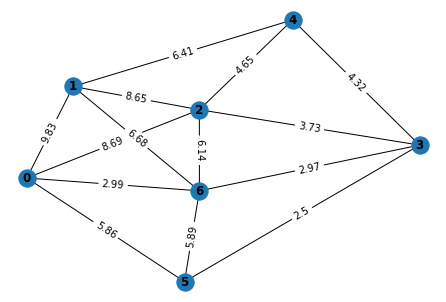

In [2]:
def generate_random_connected_graph(num_nodes, max_weight):
    """Generate a connected graph with a random number of nodes, edges, and weights"""
    num_edges = random.randint(num_nodes-1, math.floor(num_nodes*(num_nodes-1)/2)) # Randomly choose the number of edges
    # Create a list of numbers up to the number of nodes, and shuffle it 
    nodes = list(range(num_nodes))
    random.shuffle(nodes)

    edges = [] # A list of unweighted edges
    # Create randomly connected graph with the minimum number of edges
    for i in range(num_nodes-1):
        edges.append([nodes[i], nodes[i+1]])
        num_edges -= 1 # Decrement the total number of edges that haven't been generated yet

    # Randomly generate extra edges
    for i in range(num_edges):
        # Loop until a valid edge is found
        while True:
            start_node = random.randint(0, num_nodes)
            end_node = random.randint(0, num_nodes)
            # Must be a unique edge between two distinct points
            if (start_node != end_node and [start_node, end_node] not in edges):
                edges.append([start_node, end_node])
                break

    # Create graph from edges
    G = nx.Graph()
    for edge in edges:
        rand_weight = round(random.uniform(0, max_weight), 2) # Weights can be floats. Round to the nearest hundredth 
        G.add_edge(edge[0], edge[1], weight = rand_weight)
    return G

test_graph = generate_random_connected_graph(6, 10)
pos = nx.spring_layout(test_graph)
nx.draw(test_graph, pos, with_labels = True, font_weight = 'bold')
labels = nx.get_edge_attributes(test_graph, 'weight')
nx.draw_networkx_edge_labels(test_graph, pos, edge_labels = labels)

# Creating our Cost function
___
How do we determine whether the edge between two nodes has been cut? We'll give each node belonging to one subset a value of 1, and each node belonging to the other subset a value of -1. We want to create a function $C(s)$ such that $C(s) = 1$ if the nodes belong to opposite subsets (increasing the "score") and $C(s) = 0$ if the nodes belong to opposite subsets (which would not increase the score).

Let's figure out how to do this. Let $s_i$ and $s_j$ represent the values of two nodes (either 1 or -1). Notice that if both nodes belong to the same subset, then $s_is_j = 1$, whereas if they belong to opposite subsets, $s_is_j = -1$. However, since we want our function to *increase* the score when $s_i \neq s_j$, we'll multiply by result by $-1$. 

So far, we have $C(s) = -s_is_j$, which gives us $C(s) = 1$ if $s_i \neq s_j$, and $C(s) = -1$ if $s_i = s_j$. To finish constructing our function, we'll add 1 to $-s_is_j$ and then divide by 2: 
$$C(s) = \frac{1}{2}(1-s_is_j)$$

Notice that this gives us exactly what we want: if $s_i \neq s_j$, then $C(s) = 1$, and if $s_i = s_j$, then $C(s) = 0$. However, we're not quite done. This function only gives us the result for one node. To find the total "score" of our solution, we need to sum over all neighboring nodes:
$$C(s) = \frac{1}{2}\sum_{i,j \in E}{(1-s_is_j)}$$ Where $E$ is the set of edges. *This* is the cost function that we are trying to maximize.

## Mapping our Cost Function to a Hamiltonian
To solve our problem on a quantum computer, we encode our problem in a Cost Hamiltonian $H_C$. First, let's reformulate our cost function like this: 

$$C(s) = \frac{1}{2}\sum_{i,j \in E}{(-s_is_j) + const}$$

First, we'll drop the constants, leaving us with a new objective function $C'$

$$C'(s) = \sum_{i,j \in E}{-s_is_j}$$

Our goal is to maximize $C'(s)$. To map this to a cost Hamiltonian we'll replace $s_i$ and $s_j$ with Pauli Z operators $\sigma_i^z$ and $\sigma_j^z$ acting on qubits $i$ and $j$ respectively. This works because -1 and 1 are the eigenvalues of the Pauli matrices. So far, our cost hamiltonian looks like this:

$$H_C = \sum_{i,j \in E}{(-\sigma_i^z\sigma_j^z)}$$

There's just *one* more thing we need to do: the above hamiltonian only works for an unweighted graph. To generalize it for weighted maxcut problems, we multiply by the weight of the edge, $w_{ij}$. Our final cost hamiltonian looks like this:

$$H_C = \sum_{i,j \in E}{-\sigma_i^z\sigma_j^zw_{ij}}$$

## The Mixer Hamiltonian
In addition to our cost hamiltonian $H_C$, we'll also need another Hamiltonian $H_B$ (often called the "Mixer Hamiltonian") which will be used to escape local minimums. This can be any Hamiltonian that doesn't commute with $H_C$. The one we're going to use is a simple Pauli X operator: 

$$H_B = \sum_{i \in V}\sigma_i^x$$

# Constructing Unitary Operators
___
Alright, we have our hamiltonians, but what do we do with them? What we do in QAOA is implement paramterized unitary operators corresponding to our hamiltonians. With our Cost Hamiltonian $H_C$. we create an operator $U(H_C, \gamma) = e^{-i \gamma H_C}$, and with our Mixer Hamiltonian $H_B$, we create an operator $U(H_B, \beta) = e^{-i \beta H_B}$. 

Whoa, hold on, what does all this exponentiated hamiltonian stuff mean? The section "Background: Quantum Mechanics" in [this article](https://www.mustythoughts.com/quantum-approximate-optimization-algorithm-explained) does a great job explaining it. Basically, we can think of $e^{-itH}$ as the evolution of the state of the quantum system for time $t$, as described by the hamiltonian $H$. Our unitaries $e^{-i \gamma H_C}$ and $e^{-i \beta H_B}$ do something like this for the hamiltonians $H_C$ and $H_C$. We've constructed our hamiltonians in such a way that each of our hamiltonian can be thought of as a matrix that rotates the qubits of our system around a particular axis of the bloch sphere. Instead of evolving the state for a time $t$, we're evolving the state by rotating the qubits by an angle proportional to our parameters $\gamma$ and $\beta$. To solve the maxcut problem, all we need to do is find the optimal parameters.

So how do we use these unitary operators? Well, let's breifly recall what QAOA does.

We start with $n$ qubits (where $n$ is the number of nodes in our graph) and we apply a Hadamard gate on each one, creating an equal superposition state $|+...+\rangle$. We'll call this state $|s\rangle$. Then we repeatedly apply our parametrized cost and mixer unitaries to construct the following state: 

$$U(H_B, \beta_p)U(H_C, \gamma_p)...U(H_B, \beta_1)U(H_C, \gamma_1)|s\rangle$$

Overall, the QAOA circuit looks like this:

![QAOA Circuit Diagram](qaoa_circuit.png)

The repetition of applying our cost and mixer unitaries in an alternating fashion is called Trotterization. It a is a way of approximating the adiabatic pathway.

## Turning our Unitary Operators into Gates
To actually create our quantum circuit, we need to be able to express our unitary operators as a series of gates. How do we do that?

First, let's figure out how to translate are cost unitary to quantum gates. Remember that our cost unitary is $e^{-i\gamma H_C} = e^{-i\gamma (-\sigma_i^z\sigma_j^zw_{ij})}$

One gate that will be useful is the $R_z$ gate, which rotates the state around the $z$ axis of the bloch sphere by an angle $\frac{\theta}{2}$:

$$R_z(\theta) = e^{-i\frac{\theta}{2}\sigma_z} = 
\cos{\frac{\theta}{2}}I - i\sin{\frac{\theta}{2}}\sigma_z =
\begin{bmatrix} 
e^{-i\frac{\theta}{2}} & 0 \\
0 & e^{i\frac{\theta}{2}}
\end{bmatrix}$$

Of course, this is only a one-qubit gate. How do we implement the two-qubit unitary $e^{-i\frac{\theta}{2}\sigma_i^z\sigma_j^z}$? One way to see what the effect of this unitary is to observe the effect of applying it to all computational basis states, and replacing the Pauli Z operators with their eigenvalues corresponding to the computational basis states. This slide from Ruslan Shaydulin [tutorial](https://www.youtube.com/watch?v=AOKM9BkweVU&list=WL&index=21&t=948s) explains it well: ![Effect of unitary on all computational basis states](gate_mapping.png)

We can use the CNOT gate to check the parity of qubit $i$ and qubit $j$, then apply our $R_z$ gate, and then add another CNOT to undo the effect of the first CNOT. The resulting circuit looks like this: ![Cost Unitary Circuit](gate_mapping2.png)
In this case, $t$ represents the parameter we pass in (either $\gamma$ or $\beta$). The reason we multiply by two is because the $R_z(\theta)$ gate rotates by $\frac{\theta}{2}$, so multiplying by 2 allows us to rotate by $\gamma$ or $\beta$.

Finally, we need to translate our mixer unitary into gates. This one is easy: just as single-qubit $R_x(2\beta)$ gate. (We're multiplying by 2 for the same reason we did this for our cost unitary).

In [3]:
# Hamiltonians
def create_cost_unitary(graph, gamma):
    """Implement the cost unitary on a quantum circuit"""
    
    cost_unitary = QuantumCircuit(len(graph.nodes), name="Cost Unitary")
    weights = nx.get_edge_attributes(graph, 'weight').values() # Get weights from graph
    
    # Add corresponding gates for each edge
    for edge, weight in zip(graph.edges, weights):
        cost_unitary.cx(int(edge[0]), int(edge[1]))
        cost_unitary.rz(2*gamma*weight, int(edge[1]))
        cost_unitary.cx(int(edge[0]), int(edge[1]))
        cost_unitary.barrier() # Visually the unitary for each edge
    #cost_unitary.to_gate()
    return cost_unitary

def create_mixer_unitary(graph, beta):
    """Implement the mixer unitary on a quantum circuit"""
    mixer_unitary = QuantumCircuit(len(graph.nodes), name="Mixer Unitary")
    
    # Apply unitary for each node
    for node in graph.nodes: 
        mixer_unitary.rx(2*beta, int(node))
        mixer_unitary.to_gate()
    return mixer_unitary

### Unitary Operator Circuit Demo

This is what it would look like if we applied the cost unitary for every edge on our test graph.

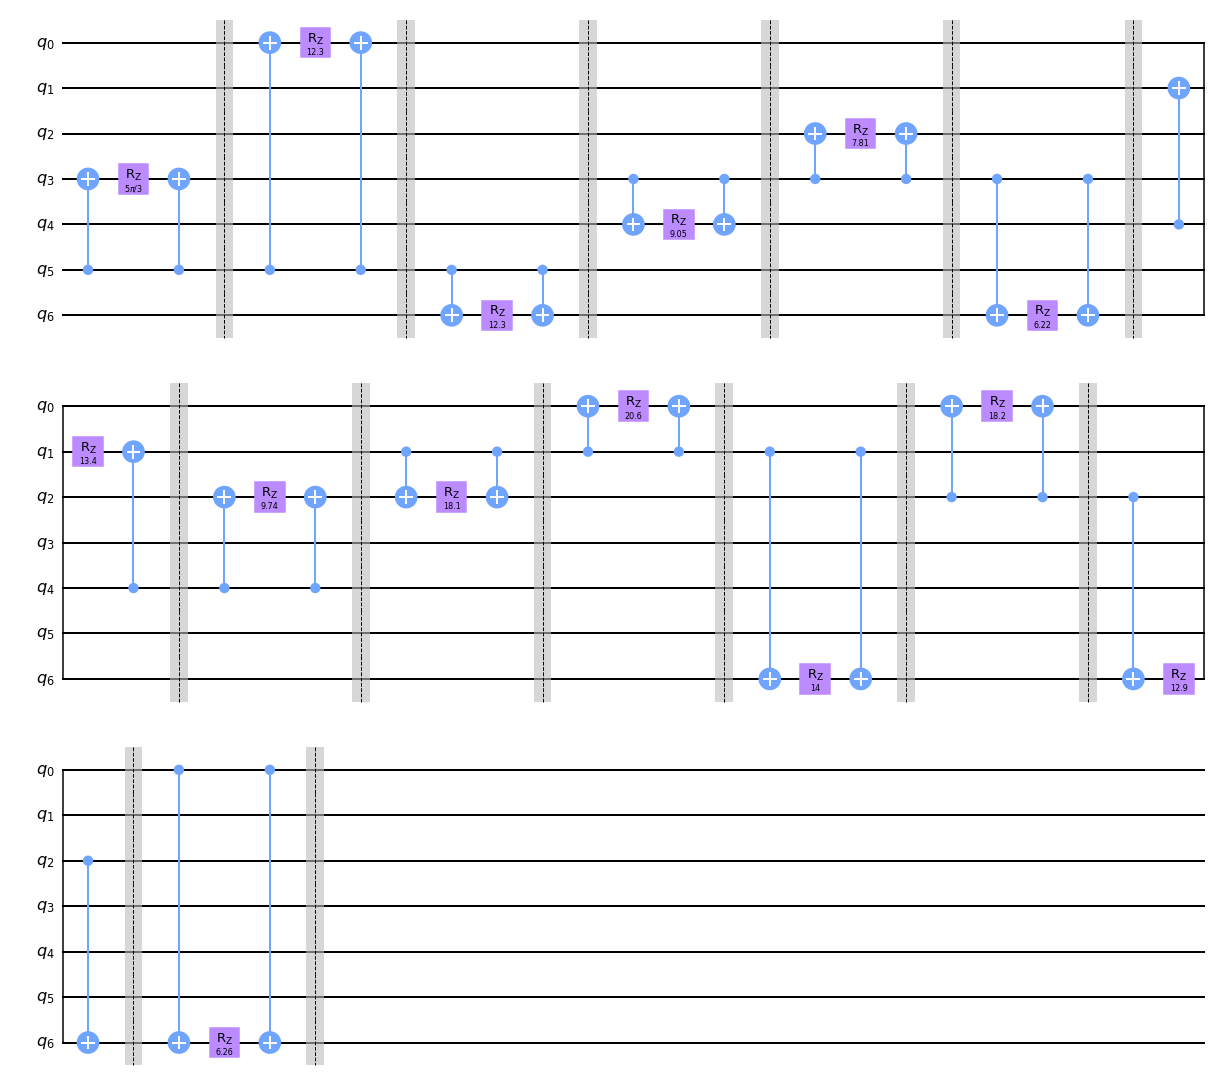

In [4]:
# A demonstration of what the cost unitary circuit might look like
test_cost_unitary = create_cost_unitary(test_graph, np.pi/3) # pi/3 is an arbitrarily chosen angle for demonstration
test_cost_unitary.draw('mpl')

And this is what the applying the mixer unitary would look like for each node.

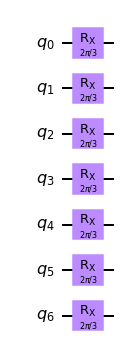

In [5]:
# A demonstration of what the mixer unitary circuit might look like
test_mixer_unitary = create_mixer_unitary(test_graph, np.pi/3)
test_mixer_unitary.draw('mpl')

Finally, we can create our QAOA circuit. The number of qubits and is the same as the number of nodes in our graph. We start by applying a layer of Hadamard gates to produce our initial superposition state $|s\rangle$. Then, we alternate applying our cost and mixer unitaries. Each time we apply a layer of cost and mixer unitaries corresponds to one iteration.

In [6]:
def create_qaoa_circuit(graph, params):
    """Create the full QAOA circuit for the graph with the given parameters."""
    num_of_iterations = int(len(params)/2)
    gammas = params[:num_of_iterations] # Let the first half of the params list be gamma parameters
    betas = params[num_of_iterations:] # Let the second half of the params list be beta parameters

    # Initialize Circuit
    qr = QuantumRegister(len(graph.nodes))
    cr = ClassicalRegister(len(graph.nodes))
    circuit = QuantumCircuit(qr, cr)

    # Put all qubits in superposition with hadamard gates
    circuit.h(qr)
    for iteration in range(num_of_iterations):
        # Get Cost and Mixer Unitaries
        cost_unitary = create_cost_unitary(graph, gammas[iteration])
        mixer_unitary = create_mixer_unitary(graph, betas[iteration])
        circuit.append(cost_unitary, qr)
        circuit.append(mixer_unitary, qr)

    circuit.measure(qr, cr)

    return circuit
  

Next, we want to find the expectation $\langle\psi|C|\psi\rangle$ of our QAOA circuit with the state corresponding to the parameters passed in. We can approximate this by taking the results of our quantum circuit and calculating the weighted average of the value of the cut for each bitstring.

In [7]:
def get_cut_size(graph, bit_string):
    """
    This function calculates the value of the cut associated with a given bitstring,
    meaning the weighted sum of all of the edges connecting two nodes belonging to opposite subsets.
    Since the classical optimizer is designed to compute a minimum instead of a maximum,
    we multiply our cut size by negative one.
    """
    cut_size = 0
    weights = nx.get_edge_attributes(graph, 'weight').values() # Get list of weights for each edge
    
    for edge, weight in zip(graph.edges, weights):
        start_node = int(edge[0])
        end_node = int(edge[1])
        if bit_string[start_node] != bit_string[end_node]:
            """Since the classical optimizer is designed to compute a minimum instead of a maximum,
            decrement the cut size instead of incrementing it.
            """
            cut_size -= 1*weight
    return cut_size

def get_expectation(graph, counts):
    """Return the weighted average of the results of the quantum circuit."""
    energy = 0 
    total_executions = 0
    for bit_string, frequency in counts.items():
        energy += frequency * get_cut_size(graph, bit_string)
        total_executions += frequency
    return energy / total_executions # Return the average

Next, we'll create an array of graphs that we can test our solution on! For the sake of this project, I'll only run the algorithm on the first graph, but implementing support for an array allows for scalability.

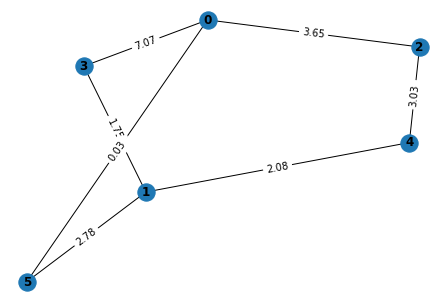

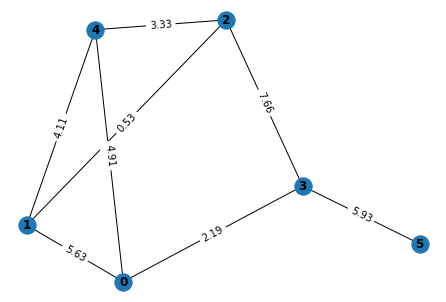

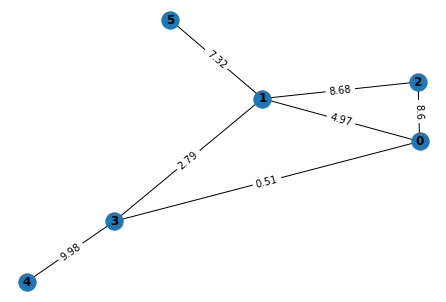

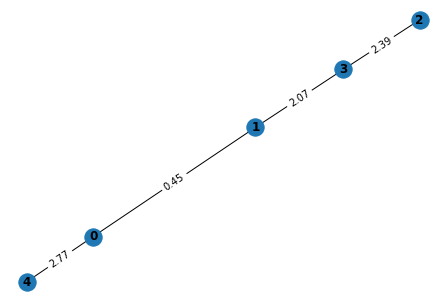

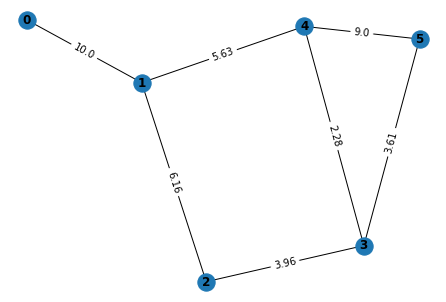

In [19]:
# Modifiable constants determining the properties of our list of graphs
NUM_OF_GRAPHS = 5
MAX_NUMBER_OF_NODES = 5
MAX_WEIGHT = 10

# Create list of graphs to perform QAOA on
graphs = []
for i in range(NUM_OF_GRAPHS):
    graphs.append(generate_random_connected_graph(MAX_NUMBER_OF_NODES, MAX_WEIGHT))

# Draw Graphs
for graph in graphs:
    plt.figure() # Display each graph separately
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels = True, font_weight = 'bold')
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels = labels)

# Classical Optimization
___
We define an objective function that the SciPy optimizer can find the optimal parameters for. The function returns the expectation of the QAOA circuit. The goal of the optimizer we choose will be to minimize this expectation value.

In [20]:
CURRENT_GRAPH = graphs[0]
def objective(params):
    backend = Aer.get_backend("qasm_simulator")
    circuit = create_qaoa_circuit(CURRENT_GRAPH, params)
    counts = execute(circuit, backend).result().get_counts()
    counts = {key[::-1]:value for key, value in counts.items()} # Invert bitstrings because Qiskit uses different order
    return get_expectation(CURRENT_GRAPH, counts)


Here, we define our initial list of parameters that SciPy will optimize. The length of this list determines the depth of our circuit (how many iterations we want to apply our unitary layers for). We'll initialize a random set of parameters between 0 and $\pi$

In [21]:
NUM_OF_ITERATIONS = 3
init_params = [random.uniform(0,np.pi) for i in range(2*NUM_OF_ITERATIONS)]

solution = minimize(objective, init_params, method = "COBYLA")
print(solution)

     fun: -14.68439453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 70
  status: 1
 success: True
       x: array([4.06844933, 0.15690518, 1.42738659, 0.87646885, 0.29846743,
       3.42030986])


Now that we've found the optimal parameters, let's plug them into our QAOA circuit and see the results! The spikes on the graph correspond to the best solutions.

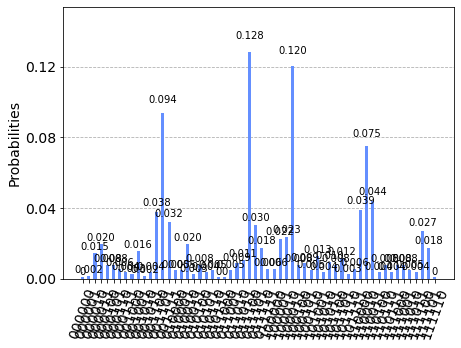

In [22]:
backend = Aer.get_backend("qasm_simulator")
optimized_params = solution['x']
optimal_circuit = create_qaoa_circuit(CURRENT_GRAPH, optimized_params)
counts = execute(optimal_circuit, backend).result().get_counts()
counts = {key[::-1]:value for key, value in counts.items()} # Invert bitstrings because Qiskit uses different order
plot_histogram(counts)

In [23]:
# Print Counts
for bit_string, frequency in counts.items():
    print(bit_string + ": " + str(frequency))

000000: 1
100000: 6
000010: 15
100010: 24
010010: 20
110010: 77
001010: 2
101010: 4
011010: 9
111010: 5
000110: 6
100110: 5
010110: 5
110110: 8
101110: 3
011110: 18
111110: 1
010000: 5
000001: 2
100001: 23
010001: 5
001001: 16
101001: 13
011001: 5
111001: 8
000101: 8
100101: 9
010101: 4
001101: 96
101101: 12
011101: 31
111101: 18
110000: 40
000011: 20
100011: 123
010011: 3
110011: 45
001011: 4
101011: 10
011011: 11
111011: 4
000111: 4
010111: 1
110111: 4
001111: 33
101111: 6
011111: 6
001000: 3
011000: 1
111000: 8
000100: 8
100100: 8
010100: 8
110100: 4
001100: 39
101100: 8
011100: 131
111100: 28


There may be more than one solution. We'll select the bitstring with the highest frequency as our solution.

In [30]:
# Print the bitstring with the highest frequency
solution_string = max(counts, key=counts.get)
solution_cut_value = -1*get_cut_size(CURRENT_GRAPH, solution_string)
print("Our solution is " + solution_string + " with a cut value of " 
      + str(solution_cut_value))

Our solution is 011100 with a cut value of 18.61


Now let's visualize our result by coloring the graph!

{(1, 3): Text(-0.01674753771946949, 0.28545177409616207, '1.75'),
 (1, 5): Text(0.715466761029708, 0.474791601952659, '2.78'),
 (1, 4): Text(0.3195570920586174, -0.13284077817626752, '2.08'),
 (3, 0): Text(-0.5959727064172196, 0.11181633399969876, '7.07'),
 (0, 2): Text(-0.5873427933094396, -0.367133063241776, '3.65'),
 (0, 5): Text(0.13624159233195787, 0.30115616185619576, '0.03'),
 (2, 4): Text(-0.11949405461248812, -0.5866079359523575, '3.03')}

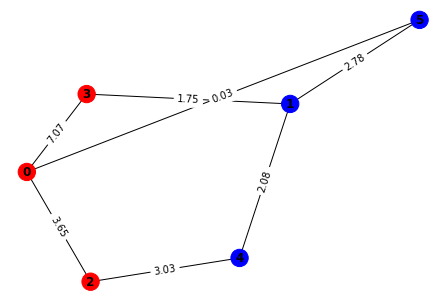

In [32]:
def color_graph(bit_string):
    """This function determines how to color a graph for a given bitstring."""
    colors = []
    for index, bit in enumerate(bit_string):
        if bit == "1":
            colors.append('r')
        elif bit == "0":
            colors.append('b')
    return colors

# Show the graph
pos = nx.spring_layout(CURRENT_GRAPH)
nx.draw(CURRENT_GRAPH, pos, with_labels=True, font_weight='bold', node_color=color_graph(solution_string))
labels = nx.get_edge_attributes(CURRENT_GRAPH, 'weight')
nx.draw_networkx_edge_labels(CURRENT_GRAPH, pos, edge_labels=labels)

How does this compare to the actual solution? To check, we'll use a brute force approach to find the solution classically.

In [33]:
# Compare QAOA Solution to actual solution
all_possibilities = {}
for bit_string, frequency in counts.items():
    all_possibilities[bit_string] = get_cut_size(CURRENT_GRAPH, bit_string)

actual_solution = min(all_possibilities, key=all_possibilities.get)
actual_solution_cut_value = -1*get_cut_size(CURRENT_GRAPH, actual_solution) # Multiply by one to get a positive result
print(f"The actual solution is {actual_solution} with a cut value of {actual_solution_cut_value}")

The actual solution is 100011 with a cut value of 18.61


And finally, let's visualize the actual solution.

{(1, 3): Text(0.01604946461088566, 0.2847479650782671, '1.75'),
 (1, 5): Text(-0.7146239765611268, 0.4636686593078169, '2.78'),
 (1, 4): Text(-0.31626451499441, -0.12780905025779288, '2.08'),
 (3, 0): Text(0.5948398177769747, 0.11336473757454996, '7.07'),
 (0, 2): Text(0.5855910738223974, -0.3598274981764227, '3.65'),
 (0, 5): Text(-0.13583362339503774, 0.29228543180409977, '0.03'),
 (2, 4): Text(0.11978415878415191, -0.5770333968823671, '3.03')}

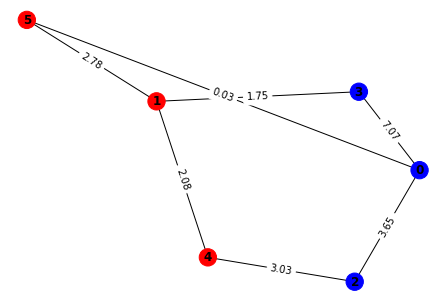

In [34]:
pos = nx.spring_layout(CURRENT_GRAPH)
nx.draw(CURRENT_GRAPH, pos, with_labels=True, font_weight='bold', node_color=color_graph(actual_solution))
labels = nx.get_edge_attributes(CURRENT_GRAPH, 'weight')
nx.draw_networkx_edge_labels(CURRENT_GRAPH, pos, edge_labels=labels)

So how does our QAOA circuit stack up against brute force, in terms of finding the correct answer? Well, we can use the ratio between the cut value from the QAOA's answer and the cut value of the correct answer. A higher number means that our QAOA did a better job. For small graphs, we can even get the exact correct answer, resulting in a ratio of 1.0!

In [35]:
print(solution_cut_value / actual_solution_cut_value)

1.0
